In [1]:
import numpy as np
import pandas as pd
import random
from typing import List, Tuple, Callable, Literal, Union
import matplotlib.pyplot as plt
import idx2numpy
import itertools

---
1. Demuestre la siguiente identidad de acuerdo a las definiciones vistas en la clase 1, demuestre.

$$
rms(x)^2 = avg(x)^2 + stf(x)^2
$$

Sea x $\in \mathbb{R}^n$. \
Como:

$$rms(x) = \sqrt(\frac{x^2_1 + ... + x^2_n}{n}) = \frac{||x||}{\sqrt(n)}$$

$$std(x) = rms(x - avg(x)\textbf{1}) = \frac{1}{\sqrt(n)}\sqrt(\sum\limits_{i=1}^n(x_i - avg(x))^2)$$



Entonces:

$$
rms(x)^2 = avg(x)^2 + stf(x)^2
$$

$$
rms(x)^2 = avg(x)^2 + \frac{1}{n}\sum\limits_{i=1}^n(x_i - avg(x))^2
$$

$$
rms(x)^2 = avg(x)^2 + 
\frac{1}{n}\sum\limits_{i=1}^n(
    x_i^2 - 2avg(x)x_i + avg(x)^2
)
$$

$$
rms(x)^2 = avg(x)^2 + 
\frac{1}{n}\sum\limits_{i=1}^n x_i^2 

- \frac{1}{n}\sum\limits_{i=1}^n 2 avg(x) x_i 

+ \frac{1}{n}\sum\limits_{i=1}^n avg(x)^2
$$

Como avg(x) es una constante, entonces:

$$
rms(x)^2 = avg(x)^2 + 
\frac{1}{n}\sum\limits_{i=1}^n x_i^2 

- \frac{2avg(x)}{n}\sum\limits_{i=1}^n  x_i 

+ \frac{avg(x)^2 \cancel{n}}{\cancel{n}} 
$$

Luego, como:

$$avg(x) = \frac{1}{n} \sum\limits_{i=1}^nx_i$$

Entonces:

$$
rms(x)^2 = \cancel{avg(x)^2} + 
\frac{1}{n}\sum\limits_{i=1}^n x_i^2 
- \cancel{2avg(x)^2} + \cancel{avg(x)^2} 
$$

$$
rms(x)^2 = \frac{1}{n}\sum\limits_{i=1}^n x_i^2 
$$

$$rms(x) = \sqrt(\frac{1}{n}\sum\limits_{i=1}^n x_i^2) \space \space \square$$


---

---
2. Este problema trataremos el problema de clustering, es decir, determinar los k representates de un conjunto de datos y las etiquetas de estos que minimizan la distancia de cada cluster a su representante.

    - a) Programe el algortimo de k-means. Construya una rutina 
        $$k\_means\_fit(X, Z0, NITERMAX)$$
        donde X son los datos Z0 son los representates iniciales, y NITERMAX es el número máximo de iteraciones.

    - b) Use la base de datos datakmeans.csv para testear su algoritmo con k = 5 representantes. Grafique el conjunto de datos X por etiqueta y los representates de cada cluster. Grafique el comportamientov de la función respecto al número de iteraciones y discuta el número de iteraciones adecuado para el clustering.

    - c) Use la base de datos de imágenes de dígitos de MNIST para testear su algoritmo con k = 20 representantes. Grafique cada representante y uno de los datos asignados a dicho cluster. Grafique el comportamiento de la función objetivo Jclust versus al número de iteraciones y discuta el numero de iteraciones adecuado para el clustering.

    - d) Discuta porque el algoritmo de k − means converge, es decir, es seguro que de una iteración a la siguiente la función objetivo decrece?

In [2]:
class KMeans:
    def __init__(
        self, k = 2, max_iters = 100, 
        distance : Literal['euclidiana'] = 'euclidiana',
        cs_politic : Literal['mean'] = 'mean',
        init: Union[Literal['random'], Literal['k_means_plus']] = 'random'
    ):
        self.k = k
        self.max_iters = max_iters
        
        self.distance = getattr(self, f'{distance}_distance')
        self.cs_politic = getattr(self, f'{cs_politic}_selector')
        self.init = getattr(self, f'{init}_init')

        self.memory = []
        self.data = None
        self.inertia = []

    def fit(self, X):
        self.data = X

        # Select k random points as initial centroids
        centroids = self.init(X)
        
        # Loop until convergence or max iterations reached
        for i in range(self.max_iters):

            clusters = [[] for _ in range(self.k)]
            
            # Assign samples to clusters
            for idx, sample in enumerate(X):
                distances = [self.distance(sample, centroid) for centroid in centroids]
                min_dist_idx = np.argmin(distances)
                clusters[min_dist_idx].append(idx)

            # Stop criteria cluster equally        
            if (i > 0 and 
                all(set(pc) == set(nc) 
                    for pc, nc in zip(self.memory[-1][1], clusters)
                )
            ):
                break

            # Update centroids to be the mean of the points assigned to them
            self.memory.append((centroids, clusters))
            self.inertia.append(self.j_cluster(centroids, clusters))

            print('Iteration {0:n} {1:.3f}'.format(i + 1, self.inertia[-1]), end='\r')
            new_centroids = self.cs_politic(X, clusters)

            # Stop criteria centroids equally
            if np.allclose(centroids, new_centroids):
                break

            centroids = new_centroids

        self.centroids = centroids
        return self.labels_by_clusters(X, clusters)

    def labels_by_clusters(self, X, clusters):
        labels = np.zeros(X.shape[0])
        for i, cluster in enumerate(clusters):
            labels[cluster] = i
        return labels
    
    def j_cluster(self, centroids, clusters):
        j_cluster = 0
        for c, cluster in zip(centroids, clusters):
            j_cluster += sum([np.sum((self.data[v] - c) ** 2) for v in cluster])
        return j_cluster / len(self.data)

    #######################################
    #          Distances                  #
    #######################################

    def euclidiana_distance(self, X, Y):
        assert len(X) == len(Y)

        # definition
        # result = np.sqrt(np.sum([(x - y)*(x - y) for x, y in zip(X, Y)]))

        # numpy version 
        n_result = np.linalg.norm(X - Y)

        # They should be similar :)
        # if not np.allclose(n_result, result):
        #     print("Distance Warning")
        return n_result 
    
    #######################################
    #        Centroid Selection           #
    #######################################

    def mean_selector(self, X, clusters):
        return np.array([X[c].mean(axis=0) for c in clusters])
    
    #######################################
    #        Centroid Initial             #
    #######################################

    def random_init(self, X):
        return random.choices(X, k=self.k) 
    
    def k_means_plus_init(self, X):

        centroids = [random.randint(0, len(X) - 1)]
        for _ in range(self.k - 1):
            candidates = []
            for i, v in enumerate(X):
                if i in centroids: continue

                distances = [self.distance(X[c], v) for c in centroids]
                candidates.append((min(distances), i))

            _, new_centroid = max(candidates)
            centroids.append(new_centroid)

        return X[centroids]

#### Inciso B

In [3]:
df = pd.read_csv('./datakmeans.csv')
df.head()

,0,1
0,-4.272404,-9.667048
1,-1.848082,-4.687662
2,8.816753,0.101368
3,6.743281,-2.990887
4,-4.751872,-7.044639


In [4]:
model = KMeans(5)
numpy_data = df.to_numpy()
labels = model.fit(numpy_data)

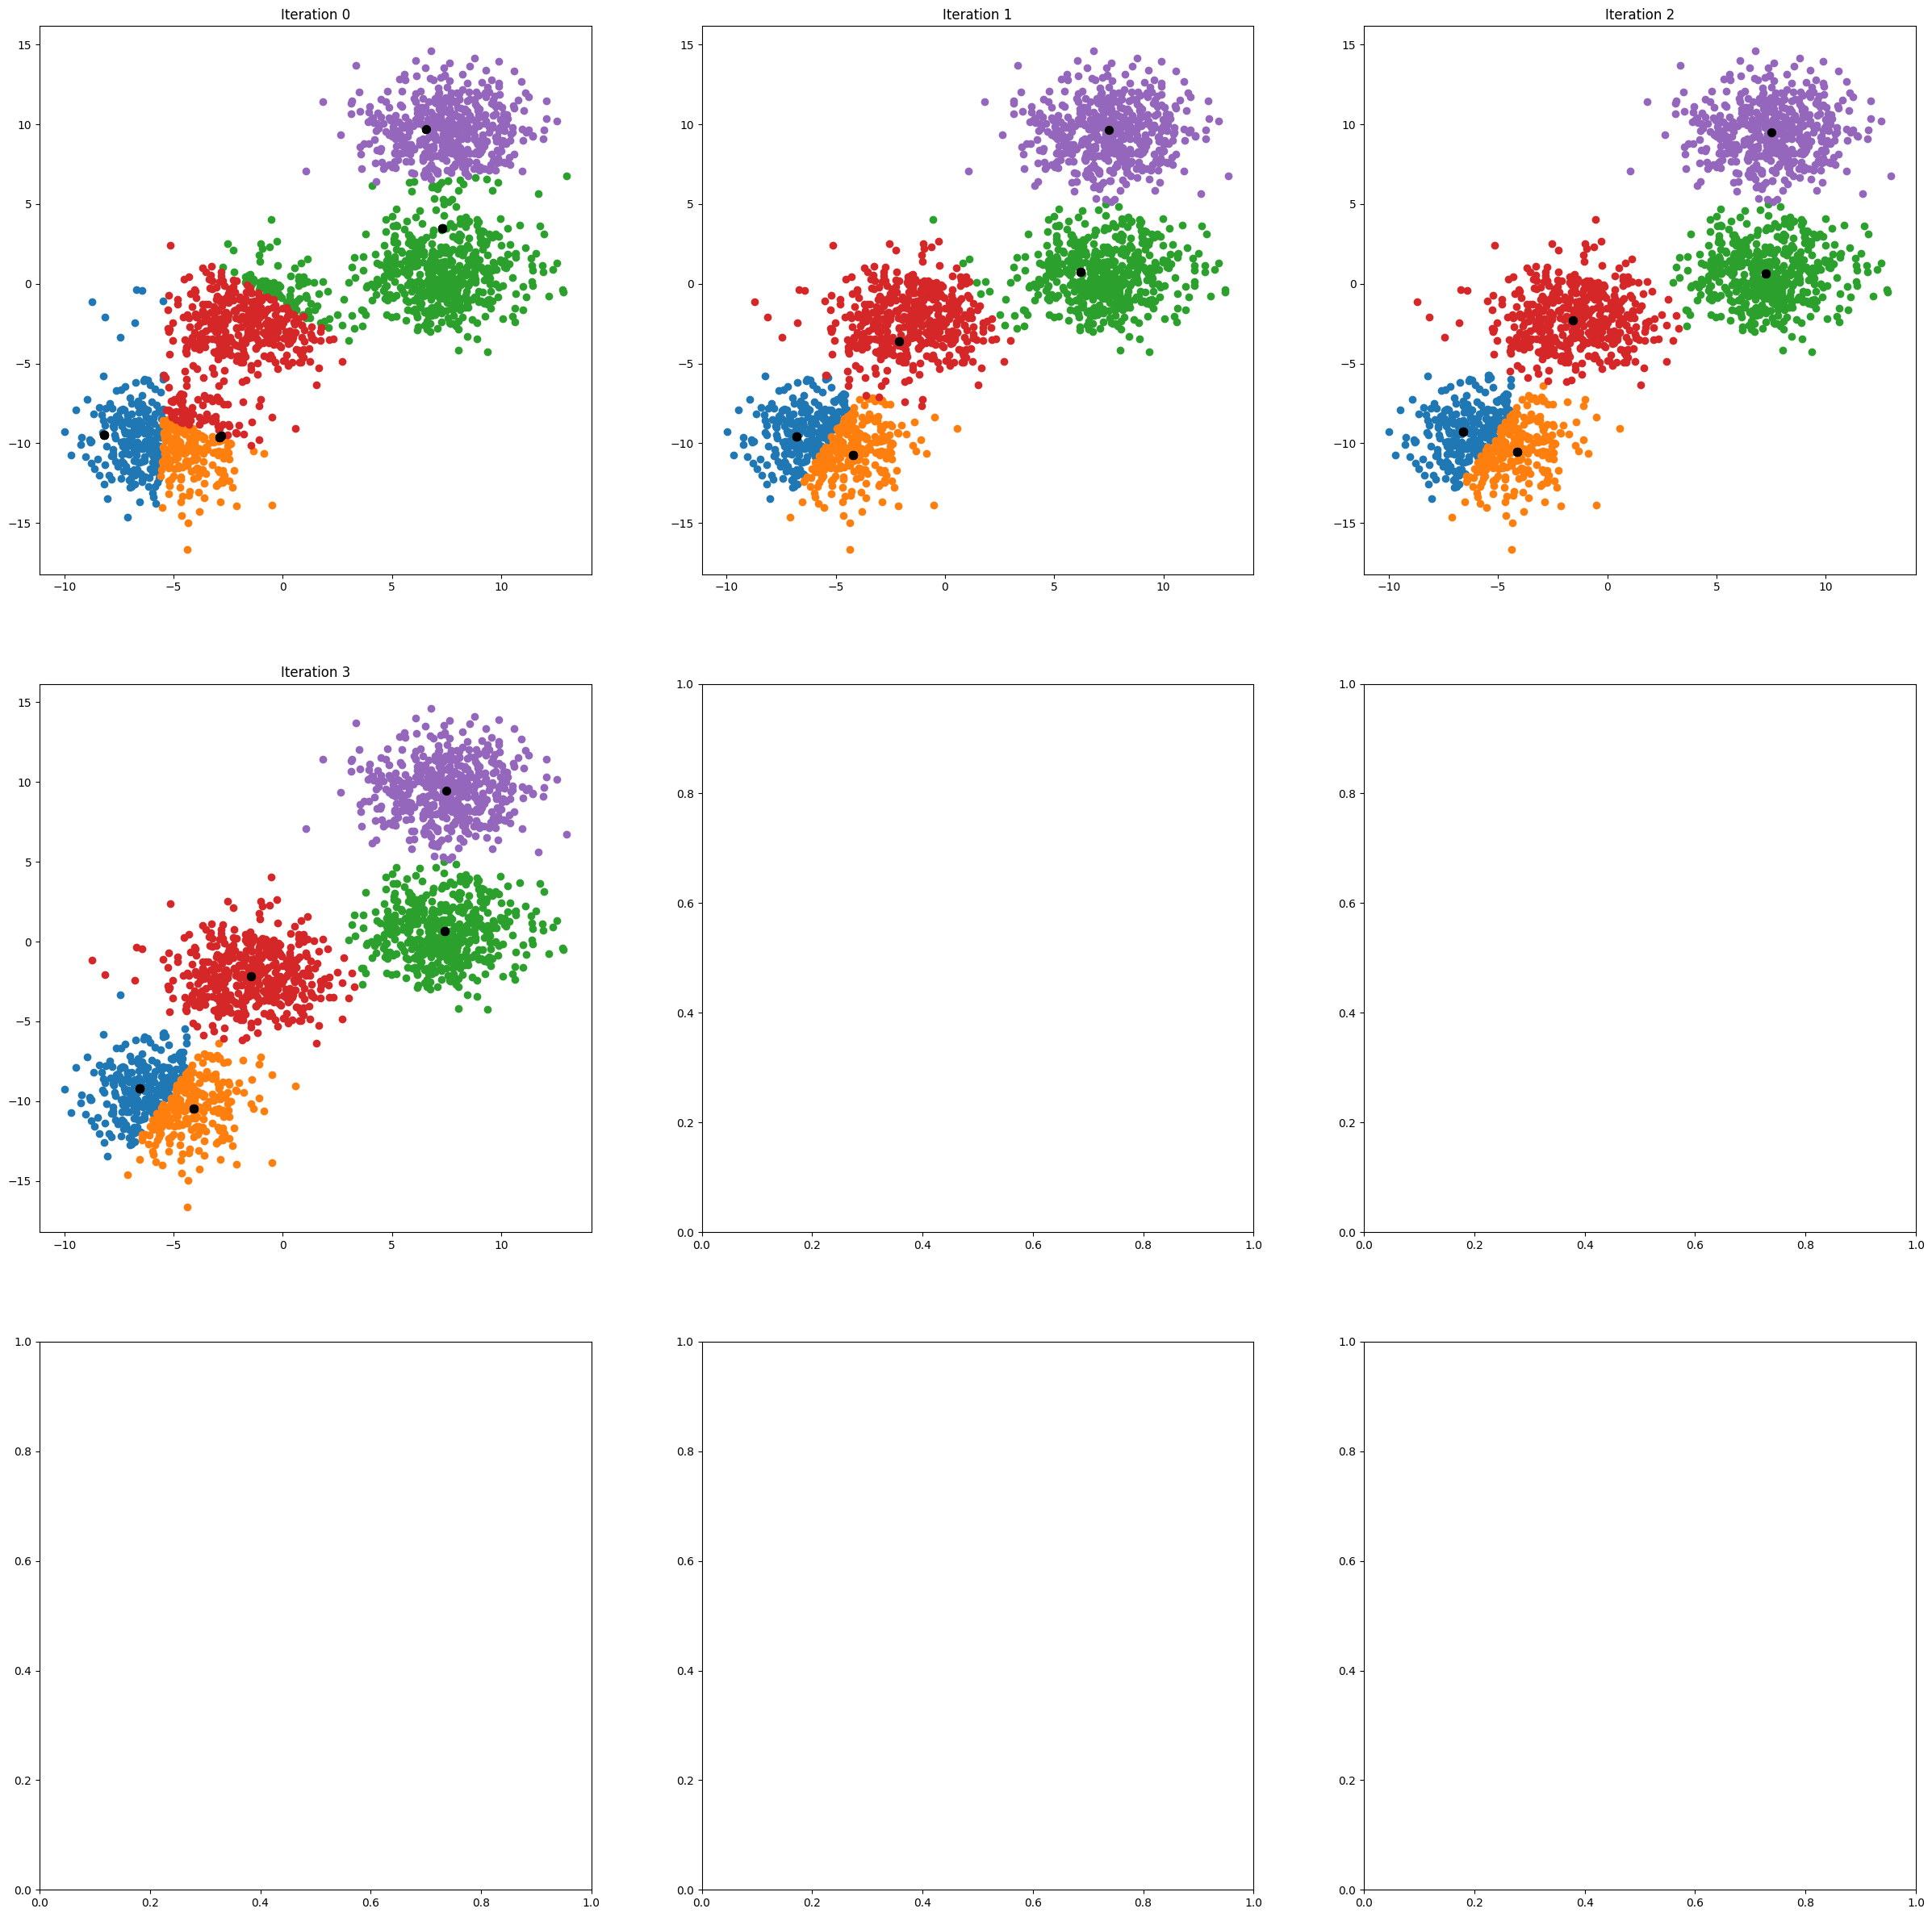

In [5]:
import math

def graphic_mosaic(model):

    rows = int(math.sqrt(len(model.memory)))
    fig, ax = plt.subplots(nrows=rows + 1, ncols=rows + 1,  figsize=(30,30))

    iter_cluster = enumerate(model.memory)
    for i in range(rows + 1):
        for j in range(rows + 1):
            try:
                index, (centroids, clusters) = next(iter_cluster)
            except StopIteration:
                break
            
            centroids = np.array(centroids)
            for col, cluster in enumerate(clusters):
                ax[i,j].scatter(
                    numpy_data[cluster,0], 
                    numpy_data[cluster,1], c=f'C0{col}'
                )
                ax[i,j].set_title(f'Iteration {index}')
                ax[i,j].scatter(centroids[:, 0], centroids[:, 1], s=50, c='black')

    plt.show()

graphic_mosaic(model)

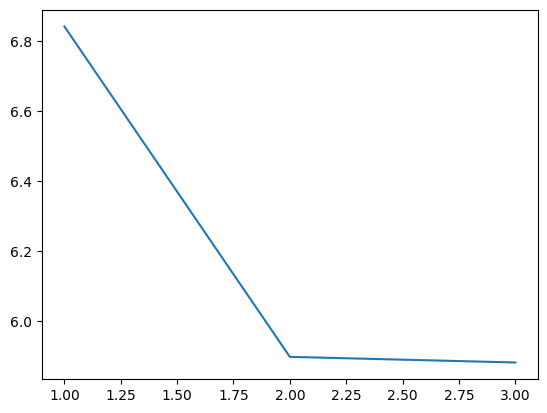

In [6]:
plt.plot(list(map(lambda x: x+ 1, range(len(model.inertia) - 1))), model.inertia[1:])
plt.show()

#### Inciso B version kmean++

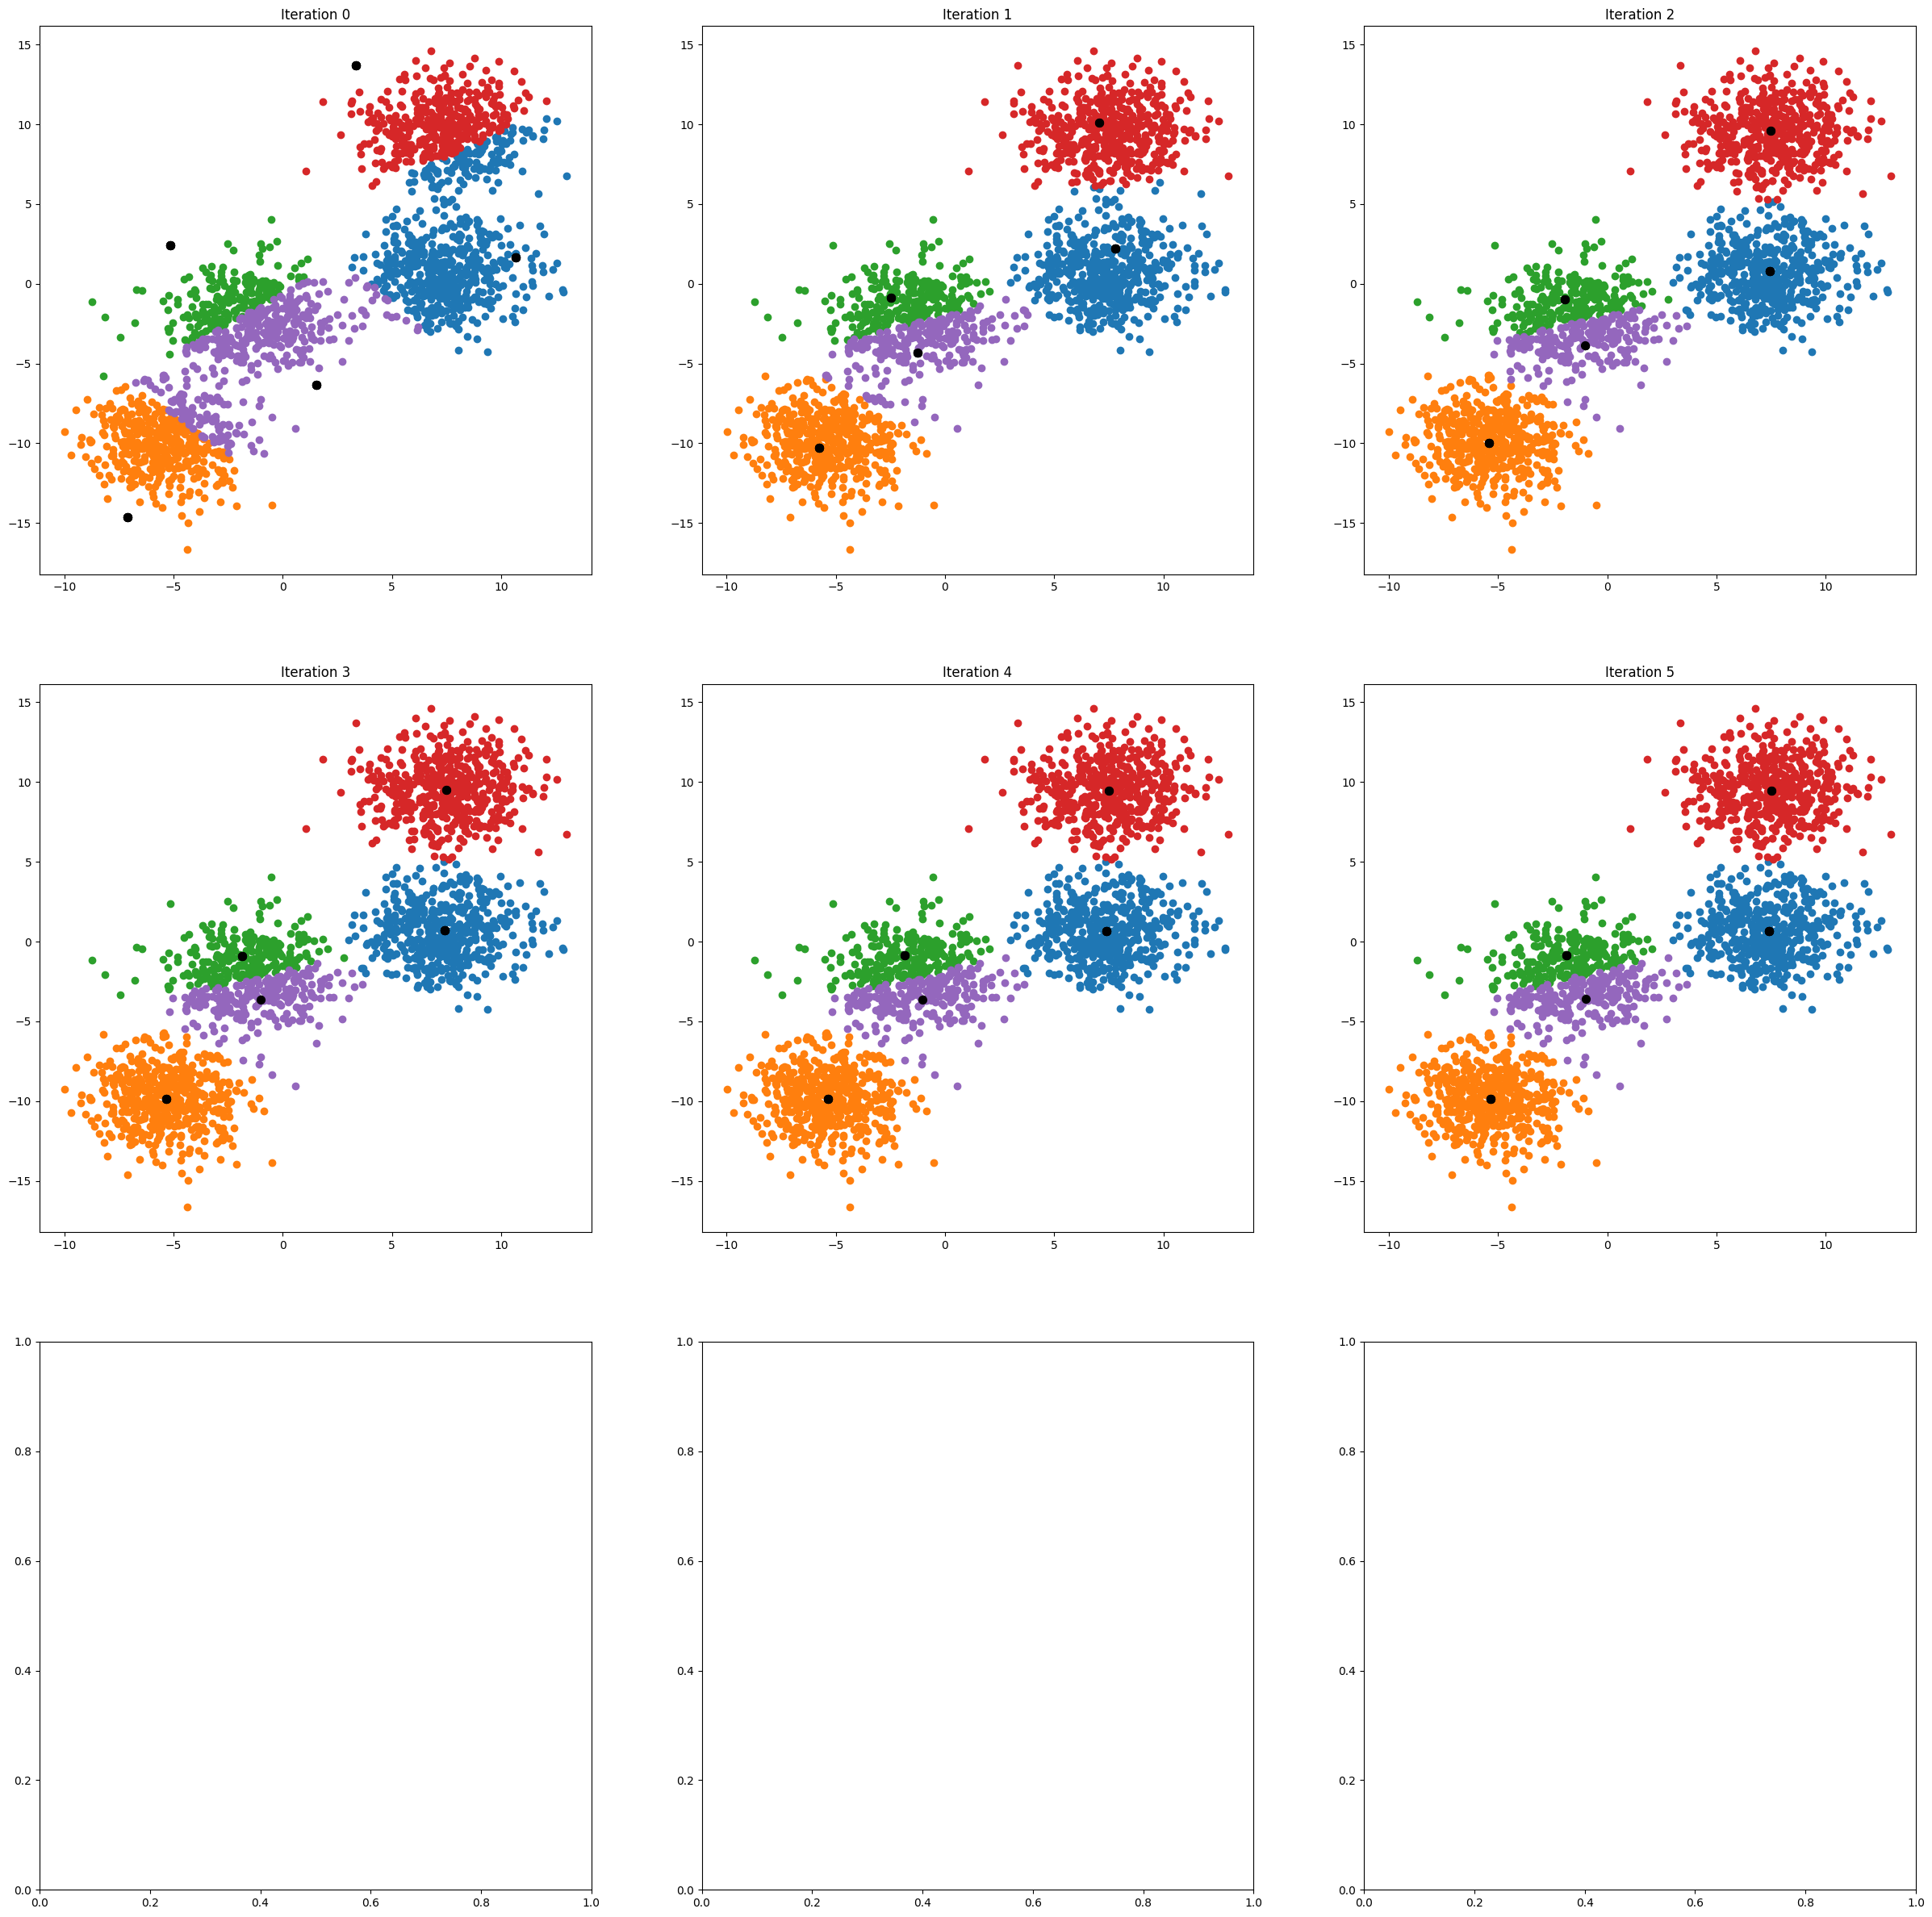

In [7]:
model_plus = KMeans(5, init='k_means_plus')
labels = model_plus.fit(numpy_data)

graphic_mosaic(model_plus)

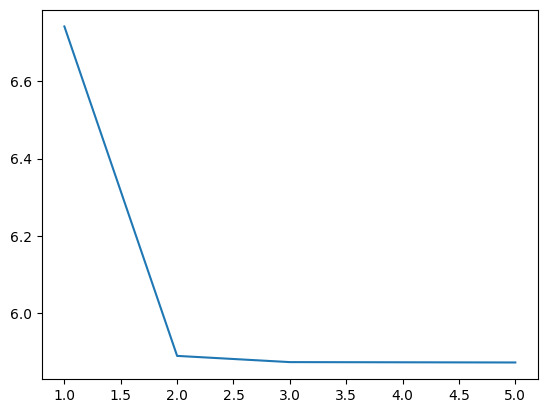

In [8]:
plt.plot(list(map(lambda x: x+ 1, range(len(model_plus.inertia) - 1))), model_plus.inertia[1:])
plt.show()

#### Discusión sobre el numero de iteraciones  

El numero de iteraciones optimas del modelo Kmeans depende fuertemente de los centroides iniciales. Esta selección no solo es importante para la determinación del numero de iteraciones sino que también influye en los clusters finales. Como este algoritmo recorre el espacio de búsqueda de forma incompleta apoyándose en un heurística entonces existe la posibilidad de que el mismo se detenga en un mínimo local antes de encontrar el optimo. Con una buena política de selección de los centroides iniciales la probabilidad de que se detecte un mínimo local se puede minimizar.  

Luego por ejemplo según los gráficos que se muestra en este resultado las iteraciones optimas de estos estudios serían entre 6-8 y 12-15 respectivamente. Pero esto solo significa que son las iteraciones optimas dados los datos y los valores iniciales

#### Inciso C

In [9]:
file = './train-images.idx3-ubyte'
arr = idx2numpy.convert_from_file(file)
arrnew = np.array([arr_j.flatten() for arr_j in arr])


kmeans = KMeans(k=20, max_iters=1000)
pred_y = kmeans.fit(arrnew)

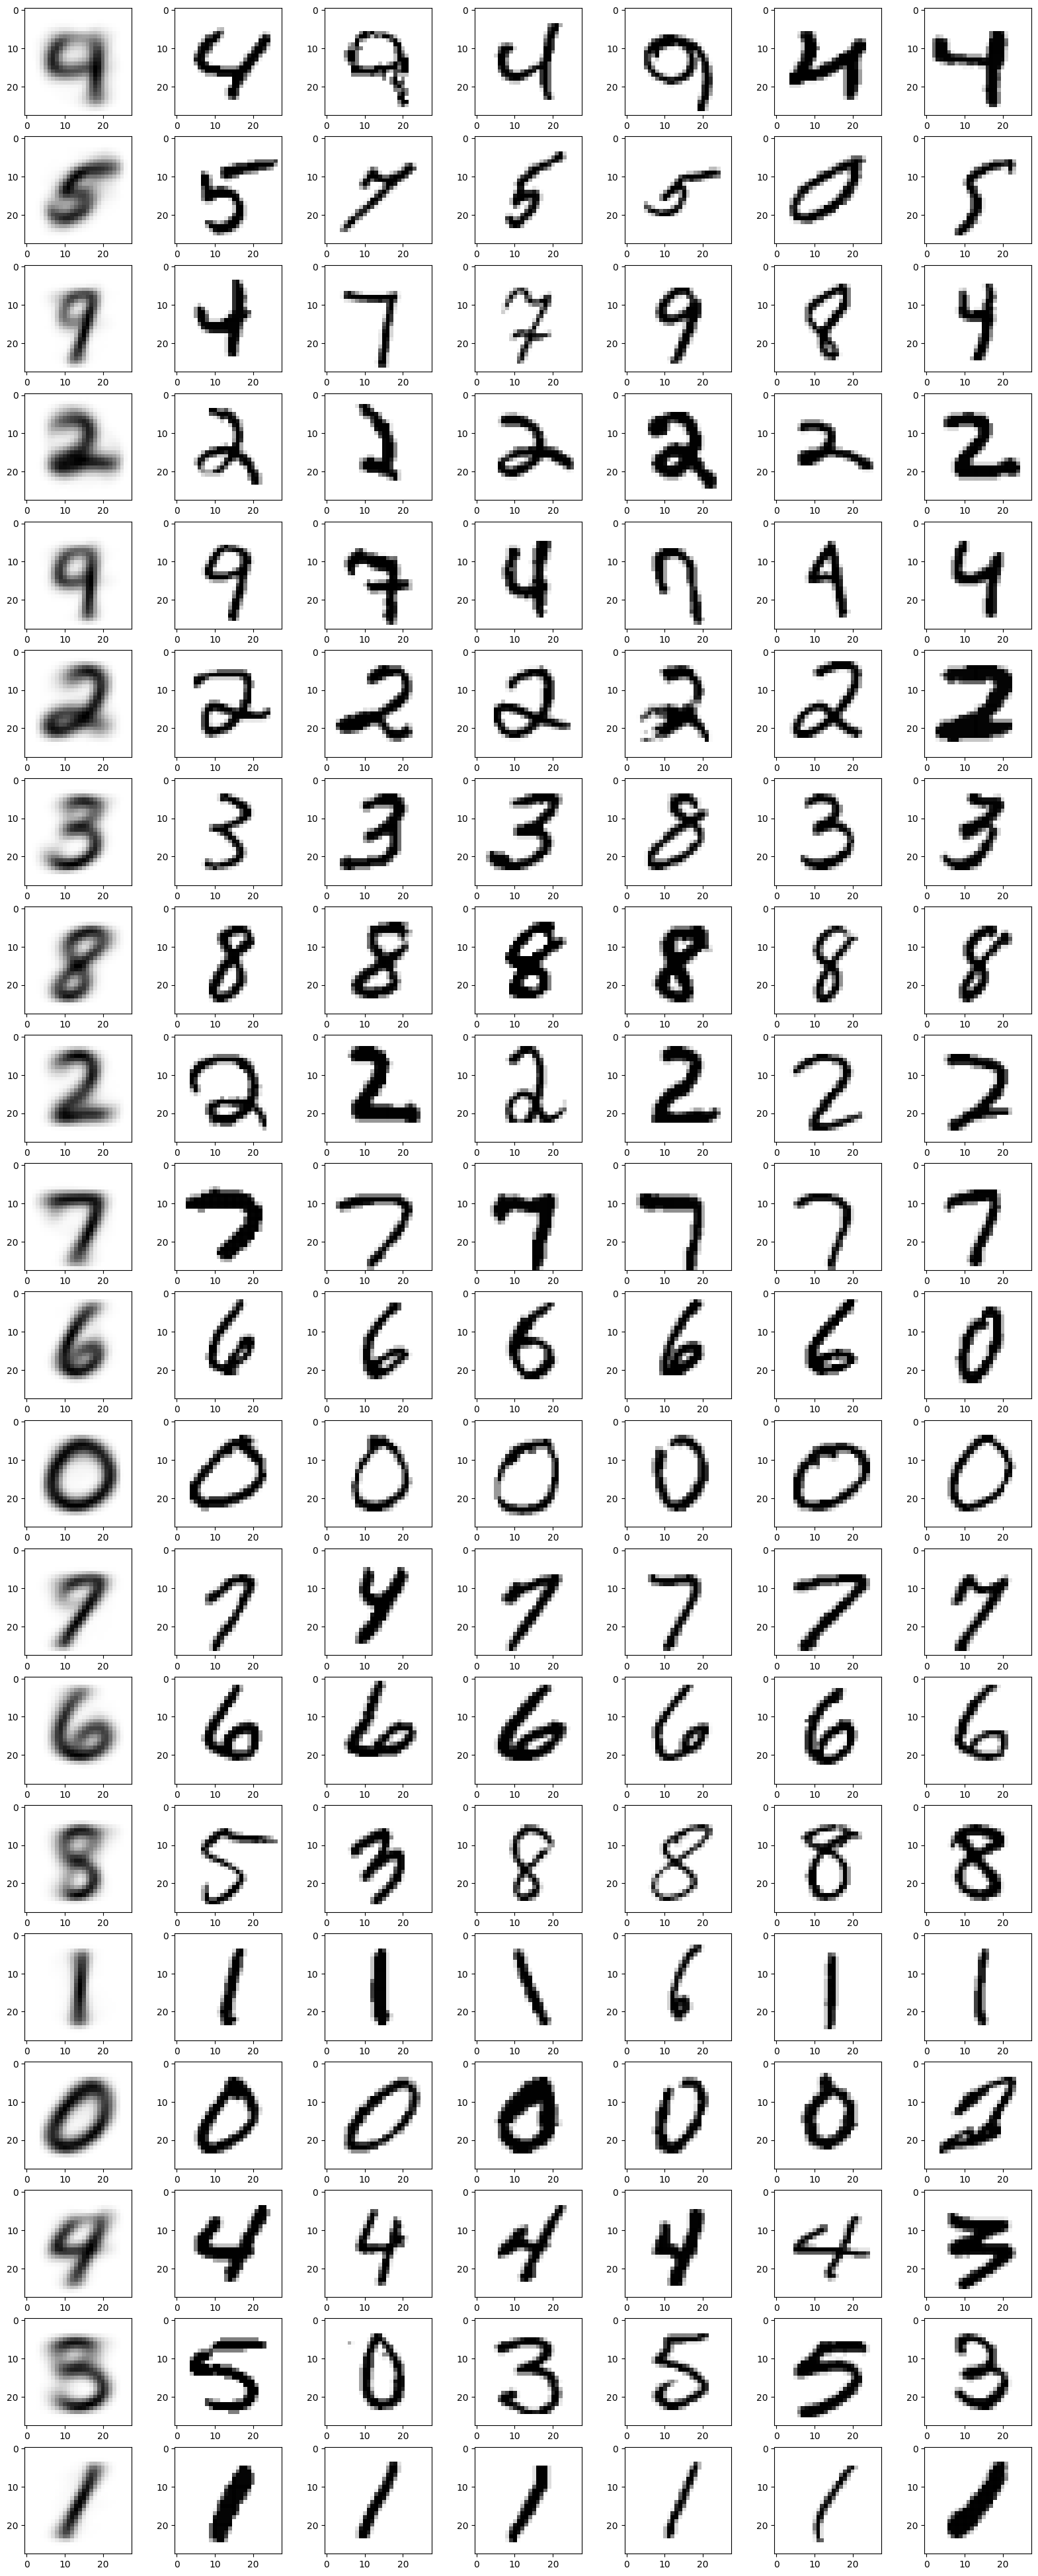

In [10]:
def graphic_numbers(centroids, labels, image_set, original_shape):
    fig, ax = plt.subplots(nrows=20, ncols=7,  figsize=(20, 50))

    for i, c in enumerate(centroids):
        sample = random.choices(image_set[labels == i], k=6)

        ax[i, 0].imshow(c.reshape(original_shape), cmap=plt.cm.binary)
        ax[i, 1].imshow(sample[0].reshape(original_shape), cmap=plt.cm.binary)
        ax[i, 2].imshow(sample[1].reshape(original_shape), cmap=plt.cm.binary)
        ax[i, 3].imshow(sample[2].reshape(original_shape), cmap=plt.cm.binary)
        ax[i, 4].imshow(sample[3].reshape(original_shape), cmap=plt.cm.binary)
        ax[i, 5].imshow(sample[4].reshape(original_shape), cmap=plt.cm.binary)
        ax[i, 6].imshow(sample[5].reshape(original_shape), cmap=plt.cm.binary)


    plt.show()

graphic_numbers(kmeans.centroids, pred_y, arr, arr[0].shape)

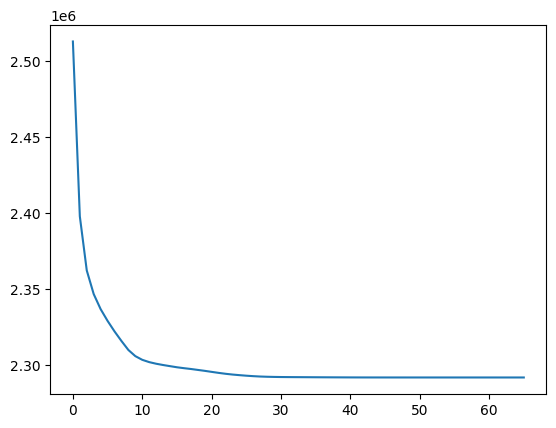

In [11]:
inertia_list = kmeans.inertia[1:]
_ = plt.plot(range(len(inertia_list)), inertia_list)

#### Discusión sobre el numero de iteraciones  

De igual forma que en el inciso anterior el numero de iteraciones depende de los centroides iniciales. Pero teniendo en cuenta la selección aleatoria realizada el numero de iteraciones optimas en este casos es entre 15-20. Pues a partir de 20 la inercia se mantiene constante

#### Inciso D

El algoritmo de k-means converge porque en cada iteración, los centroides son actualizados para minimizar la distancia Euclidiana entre cada punto y su centroide más cercano. Esto disminuye el error de cuadrado medio en cada iteración, lo que a su vez disminuye la función objetivo.

El algoritmo de k-means es un proceso iterativo donde se comienza con una asignación inicial aleatoria de centroides y se realiza el cálculo de las distancias para asignar cada punto al centroide más cercano. Luego, se actualizan los centroides para que estén en el centro de los puntos asignados. Este proceso se repite hasta que los centroides ya no se muevan (converjan) o se alcance un límite de iteraciones.

La convergencia es garantizada, debido a que en cada iteración la función objetivo se reduce para algún valor, por lo tanto en cada iteración se produce un progreso hacia la solución óptima que se busca. Sin embargo, la solución óptima alcanzada puede depender de la inicialización de los centroides y el tamaño del conjunto de datos.

---
3. Considere una matriz de A $\in R^{m×n}$ con m > n y un vector b $\in R^m$. Buscamos el vector solución $x \in R^n$ del sistema lineal Ax = b. Describa como puede asegurar de forma práctica si la solución del sistema existe o no

`R\:` Sea $A \in R^m{mxn}$ entonces la image de A se define como:

$$
ran(A) = \{ y\in R^m | \space y = Ax \space donde \space x \in R^n\}
$$

Por tanto si A = [ $a_1|a_2| .... a_n $ ] entonces ran(A) = span{$a_1,a_2, .... ,a_n$}

Luego entonces el sistema tiene solución ssi $b \in ran(A)$ y por tanto $b \in span\{a_1,a_2, .... ,a_n\}$

Finalmente el sistema tendrá solución si b es una combinación lineal de una base de span{$a_1,a_2, .... ,a_n$}.

Para comprobar esta condición necesaria y suficiente podemos emplear el método de Gram Schmidt, el mismo dado una colección de vectores devuelve una lista de vectores ortonormales base del espacio que representa los vectores de entrada. 

Luego para revisar la condición descrita basta con realizar dos ejecuciones de este método, una inicial con los vectores columna de A y una segunda con estos vectores más b. Si la dimension de las bases devueltas son iguales entonces b es pertenece al espacio determinado por las columnas de A. En casos contrario supondría que b es linealmente independiente con toda base del espacio que determinan las columnas de A y por tanto no se podría resolver el sistema 

---

In [12]:
def gram_schmidt_classic(A):

    (m, n) = A.shape
    R = np.zeros((n,n))
    Q = []
    v = np.zeros((m,n))
    for i in range(0, n):
        v[:,i] = A[:,i]

    for i in range(0, n):
        R[i,i] = np.linalg.norm(v[:,i])

        # If R[i,i] == 0 -> v[:,i] == al vector nulo
        # Por tanto el vector i es ld
        if R[i,i] == 0:
            continue

        
        new_b_i = (1.0 / R[i,i]) * v[:,i]
        for j in range(i,n):
            R[i,j] = np.dot(new_b_i,v[:,j])
            v[:,j]= v[:,j] - R[i,j] * new_b_i

        Q.append(new_b_i)

    return np.array(Q), R


In [13]:
def check_solutions(A, b):
    Q1, _ = gram_schmidt_classic(A)

    A_plus_b = np.concatenate((A, [b])) 
    Q2, _ = gram_schmidt_classic(A_plus_b)

    return Q1.shape[0] == Q2.shape[0]


A = np.array([[1,0,0],[0,1,0], [1,1,0], [1,2,0]])
b = [0,0,1]

assert not check_solutions(A, b)

A = np.array([[1,0,0],[0,1,0], [1,1,1], [1,2,0]])
b = [0,0,1]

assert check_solutions(A, b)

---
4. En este problema trataremos el problema de clasificación binaria, es decir, determinar si un dato pertenece a una de dos clases.

  - Programe el algoritmo del Perceptrón. Puede ser útil construir en este caso    una rutina 
    $$Perceptron\_fit(X, y, nitmax, eta)$$ 
    que tome los datos X, sus etiquetas y, y que retorne los pesos w delclasificador. Otros hiperparámetros a considerar son nitmax y eta quecorresponden respectivamente al número máximo de iteraciones del algoritmo y el learning rate.
  -  Programe una rutina que dado un vector de pesos w, y un conjunto de datos X prediga en a que conjunto de datos pertenece cada dato.
  - Programe una rutina que dado un vector de pesos w, un conjunto de datos X y sus etiquetas y, entregue un score de que tan bien clasificados están los datossegún las predicciones hechas por el clasificador.
  - Use las bases de datos datos1.csv y datos2.csv, grafique los datos identificando sus respectivas etiquetas y junto a ellos el resultado del hiperplano separador obtenido por su algoritmo de Perceptrón.
  - Cree 10 nuevos datos de la siguiente forma: 
  
    ```python    
    numpy.random.seed(18)
    new_data = numpy.random.random(size = (10, 2))
    new_data_labels = numpy.random.randint(2, size = 10)
    ```
    Para el primer set de datos, prediga la clase a la que pertenecen cada uno de sus datos con la función de predicción creada y calcule el score. Grafíque estos datos junto al conjunto inicial de datos y discuta la capacidad predictora de este clasificador.

In [14]:
import numpy as np

class Perceptron:
    def __init__(self, n_it_max, eta, w = None):
        self.eta = eta
        self.n_it_max = n_it_max

        if w:
            self.w = w[:-1]
            self.b = w[-1]
        
    def fit(self, X, y):
        (n, m) = X.shape
        
        # Initialize the weights
        self.w = np.random.randn(m)
        self.b = 0
        
        # The training loop
        for epoch in range(self.n_it_max):
            n_errors = 0
            
            for i in range(n):
                o = self.predict(X[i])
                if o != y[i]:
                    self.w += self.eta * (y[i] - o) * X[i]
                    self.b += self.eta * (y[i] - o)
                    n_errors += 1
            
            accuracy = 1 - (n_errors / n)
            print(f'Epoch {epoch + 1}: accuracy = {accuracy:.3f}', end='\r')
            
            if n_errors == 0:
                break
    
    def _predict(self, x):
        z = x @ self.w + self.b
        return np.heaviside(z, 1)

    def predict(self, X):
        if len(X.shape) == 1:
            return self._predict(X)

        assert len(X.shape) == 2
        labels = np.zeros(X.shape[0])
        for i, x in enumerate(X):
            labels[i] = self._predict(x)

        return labels
    
    def check_classification(self, Y, P):
        n_errors = 0
        
        for y, o in zip(Y, P):
            n_errors += o != y
        
        return 1 - (n_errors / len(Y))



In [15]:
def plot_hyperplane(X, Y, model):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))

    pos = X[Y == 1]
    ax.scatter(pos[:,0], pos[:,1], c='C00')

    neg = X[Y == 0]
    ax.scatter(neg[:,0], neg[:,1], c='C01')

    x = np.linspace(-3, 3, 5)
    y = - (model.w[0] * x + model.b) / model.w[1]

    plt.plot(x, y, c='C02')

    plt.show()

In [16]:
df = pd.read_csv('./data2.csv')

X = df[['x', 'y']].to_numpy()
Y = df['label'].to_numpy()

model = Perceptron(eta=0.01, n_it_max=100)
model.fit(X, Y)

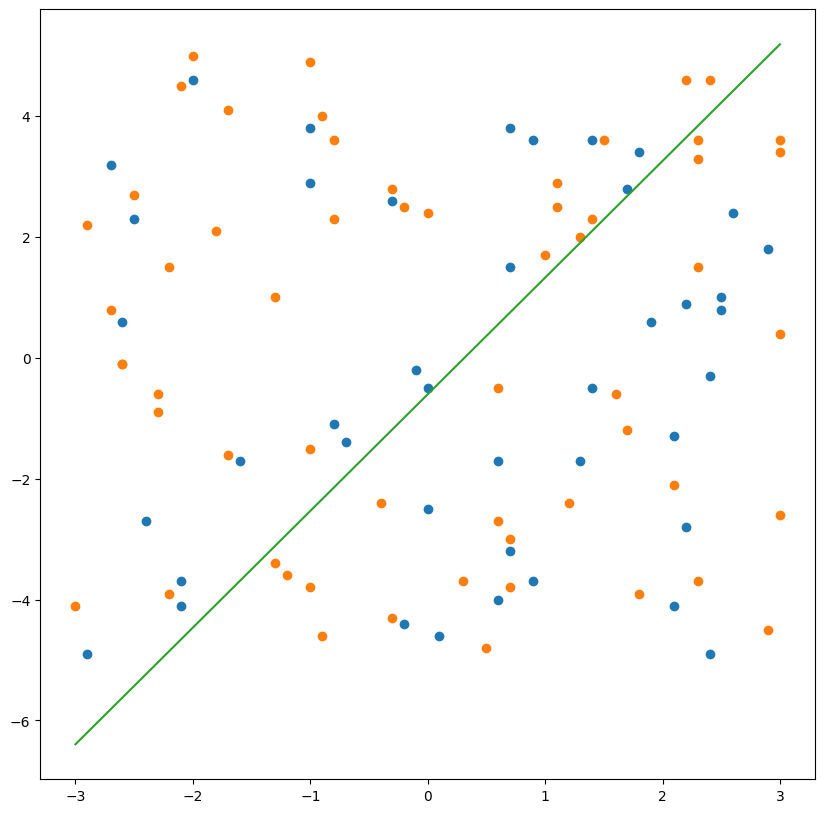

In [17]:
plot_hyperplane(X, Y, model)

In [18]:
df = pd.read_csv('./data1.csv')

X = df[['x', 'y']].to_numpy()
Y = df['label'].to_numpy()

model1 = Perceptron(eta=0.01, n_it_max=100)
model1.fit(X, Y)

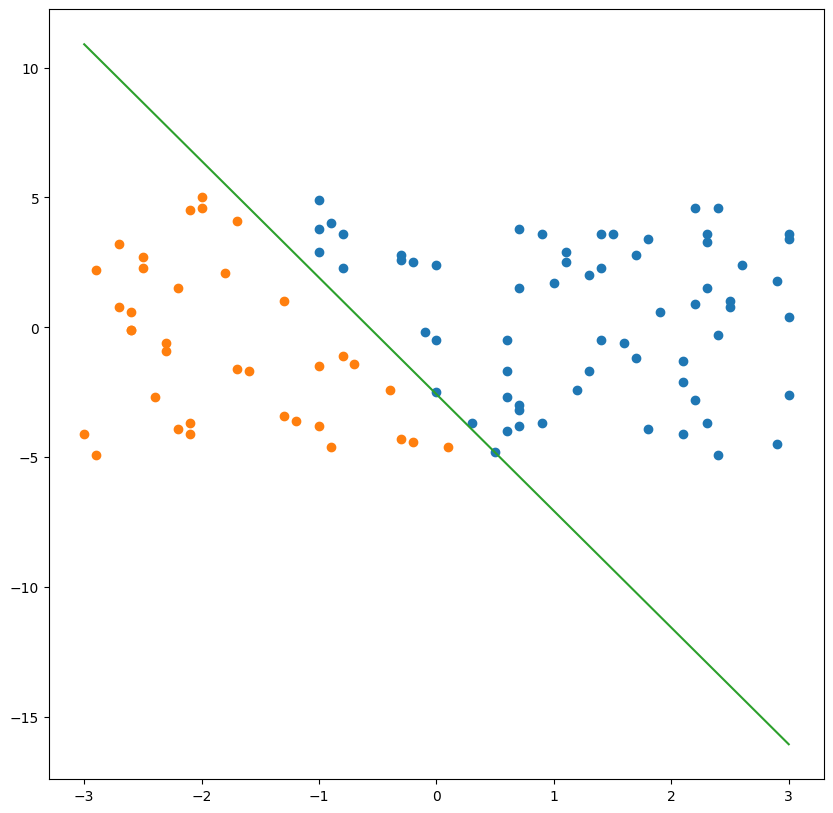

In [19]:
plot_hyperplane(X, Y, model1)

In [20]:
np.random.seed(18)
new_data = np.random.random(size = (10, 2))
new_data_labels = np.random.randint(2, size = 10)

labels = model1.predict(new_data)
accuracy = model1.check_classification(new_data_labels, labels)

print("Accuracy:", accuracy)

Accuracy: 0.6


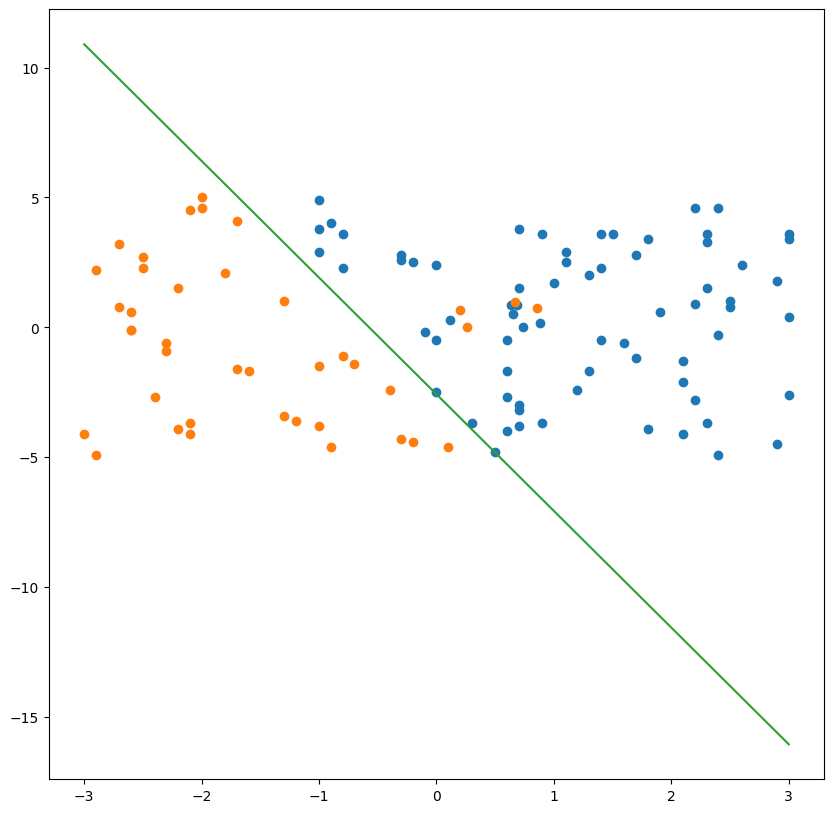

In [21]:
fake_X = np.concatenate((X, new_data))
fake_y = np.concatenate((Y, new_data_labels))

plot_hyperplane(fake_X, fake_y, model1)

#### Discusión sobre la capacidad predictiva del perceptron

El Perceptrón tiene limitaciones en su capacidad predictiva debido a su capacidad para clasificar solo datos linealmente separables. Se puede extender las capacidades predictivas de este modelo realizando modelaciones de la data para representar otros tipos de espacios, pero las relaciones encontradas en dichos nuevos espacios también serán lineales aunque en el espacio original parezcan no serlas.

Además inicialmente el algoritmo se define para clasificación de dos clases, pero tambien se puede realizar modificaciones para modelar el algoritmo multi-capa y de esta manera realizar clasificación multi-clase. 

Es un modelo bastante sencillo, pero muy interesante, pues es la base de otros modelos mucho más famosos y potentes. Además puede ser una opción más ligera a modelos más potentes como las SVM que se basan en la idea de encontrar la mejor recta que ajuste los datos. Aunque las SVM son mucho más versátiles en muchas ocasiones los buenos resultados de estas se le atribuyen a la modelación de los datos para describir otros espacios donde la información si tiene una separación lineal. En dichos casos, estos modelos podrían llegar a tener rendimientos similares     

5. Muestre que para A $\in R^{mxn}$,n con valores singulares σ_1, ..., σ_p, p = mın{m, n}, su norma esta dada por
$$
||A||_F = \sqrt(σ^2_1, + ..., + σ^2_p)
$$

$$
||A||_F = \sqrt(\sum\limits_{i=1}^m \sum\limits_{j=1}^n A^2_{ij})
$$

$$
||A||_F = \sqrt(\sum\limits_{i=1}^m \sum\limits_{j=1}^n A_{ij} A^T_{ji})
$$

Como:

$$ 
AA^T = \{ C_{ij} = \sum\limits_{i=1}^n  A_{ip} A^T_{pj}  \}
$$

Entonces:

$$
||A||_F = \sqrt tr(A A^T)
$$

Sean $U \in R^{mxm}, ⨊ \in R^{mxn} y V \in R^{nxn}$ la descomposición SVD de A entonces:

$$
||A||_F = \sqrt tr((U⨊\cancel{V^T})(\cancel{V} ⨊ U^T))
$$

$$
||A||_F = \sqrt tr(U ⨊^2 U^T)
$$

Luego sea $Z = U ⨊^2$ entonces:

$$ 
Z = \{ C_{ij} = \sum\limits_{p=1}^n U_{ip} ⨊^2_{pj}  \}
$$

Como: 
$$
⨊^2_{pj}=\begin{cases}
σ^2_{p}, & p = j \\
0, & p \ne j
\end{cases}
$$

Entonces:

$$ 
Z = \{ C_{ij} = U_{ij} σ^2_{j}  \}
$$

Luego $U ⨊^2 U^T = ZU^T$ por tanto:

$$ 
U ⨊^2 U^T = \{ C_{ij} = \sum\limits_{p=1}^n Z_{ip} U^T_{pj}  \}
$$

$$ 
U ⨊^2 U^T = \{ C_{ij} = \sum\limits_{p=1}^n U_{ip} σ^2_{p} U^T_{pj}  \}
$$

$$ 
U ⨊^2 U^T = \{ C_{ij} = \sum\limits_{p=1}^n U_{ip} σ^2_{p} U_{jp}  \}
$$

Finalmente:

$$
||A||_F = \sqrt tr(U ⨊^2 U^T)
$$

$$
||A||_F = \sqrt (\sum\limits_{i=1}^m\sum\limits_{p=1}^n U_{ip} σ^2_{p} U_{ip} )
$$

$$
||A||_F = \sqrt (\sum\limits_{p=1}^n σ^2_{p} \sum\limits_{i=1}^m  U_{ip}  U_{ip} )
$$

Sea $u_p$ la columna p de U. Entonces:

$$
||A||_F = \sqrt (\sum\limits_{p=1}^n σ^2_{p} (u^T_{p} u_{p}) )
$$

Como U es una de las matrices de la descomposición SVD de A entonces las columnas de U son vectores ortonormales y por tanto 
$u^T_{p} u_{p} = 1$. Luego:

$$
||A||_F = \sqrt (\sum\limits_{p=1}^n σ^2_{p}) \space \space \square
$$

---

6. Considere nuevamente la base de datos de imágenes de dígitos de MNIST.
  - a) Calcule la descomposicion en valores singular de la matriz de asociada a los datos utilizando la funcion svd de la librería numpy.linalg.
 - b) Utilice la SVD para reducir la dimensión de los datos a la mitad, es decir realice un analisis de componentes principales.
 - c) Grafique 10 imágenes y sus respectivas proyeccciones una vez realizado en el analisis de componentes principales.
 - d) Para los datos proyectado calcule nuevamente su algoritmo de clustering y compare con los resultados obtenidos en la pregunta 2.

In [22]:
file = './train-images.idx3-ubyte'
arr = idx2numpy.convert_from_file(file)
original_shape = arr[0].shape
print(original_shape)
image_set = np.array([arr_j.flatten() for arr_j in arr])

(28, 28)


In [23]:
avg_image = np.mean(image_set, axis=0) # size n*m by 1

# Compute eigenfaces on mean-subtracted training data
X = [image - avg_image for image in image_set] # mean centered data base
U, S, VT = np.linalg.svd(X, full_matrices=0)
print(U.shape, S.shape, VT.shape)

(60000, 784) (784,) (784, 784)


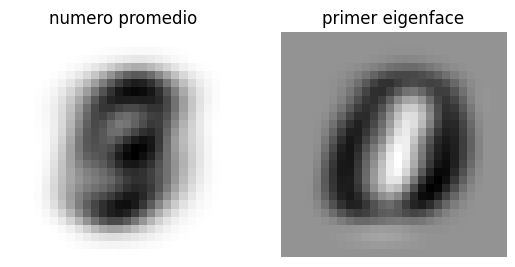

In [24]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(121)
img_avg = ax1.imshow(np.reshape(avg_image, original_shape), cmap=plt.cm.binary)
plt.title('numero promedio')
plt.axis('off')

ax2 = fig1.add_subplot(122)
img_avg = ax2.imshow(np.reshape(VT[0, :], original_shape), cmap=plt.cm.binary)
plt.axis('off')
plt.title('primer eigenface')

plt.show()

In [25]:

pca = VT[:int(image_set.shape[1]/2), :]
print(pca.shape, image_set.shape)

project_image_set = image_set @ pca.T
print(project_image_set.shape)

back_step = project_image_set @ pca
print(back_step.shape)

(392, 784) (60000, 784)
(60000, 392)
(60000, 784)


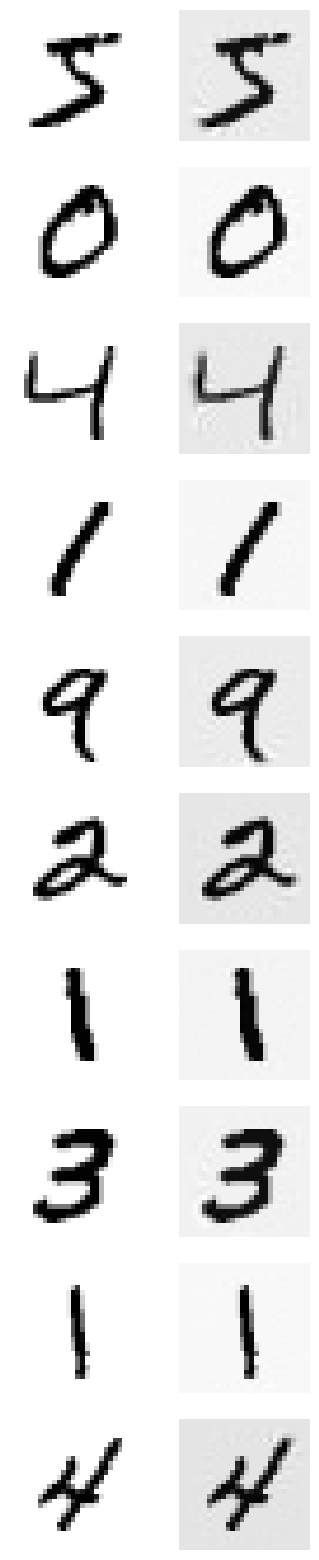

In [26]:
fig, ax = plt.subplots(nrows=10, ncols=2,  figsize=(4,20))

for index, image, projection in zip(range(10), image_set, back_step):
    img = ax[index, 0].imshow(np.reshape(image, original_shape),cmap=plt.cm.binary)
    ax[index, 0].axis('off')

    img = ax[index, 1].imshow(np.reshape(projection, original_shape),cmap=plt.cm.binary)
    ax[index, 1].axis('off')

plt.show()

In [27]:
kmeans = KMeans(k=20, max_iters=1000)
pred_y = kmeans.fit(project_image_set)

In [28]:
print(np.array(kmeans.centroids).shape, pca.shape)
centroids = np.array(kmeans.centroids) @ pca

(20, 392) (392, 784)


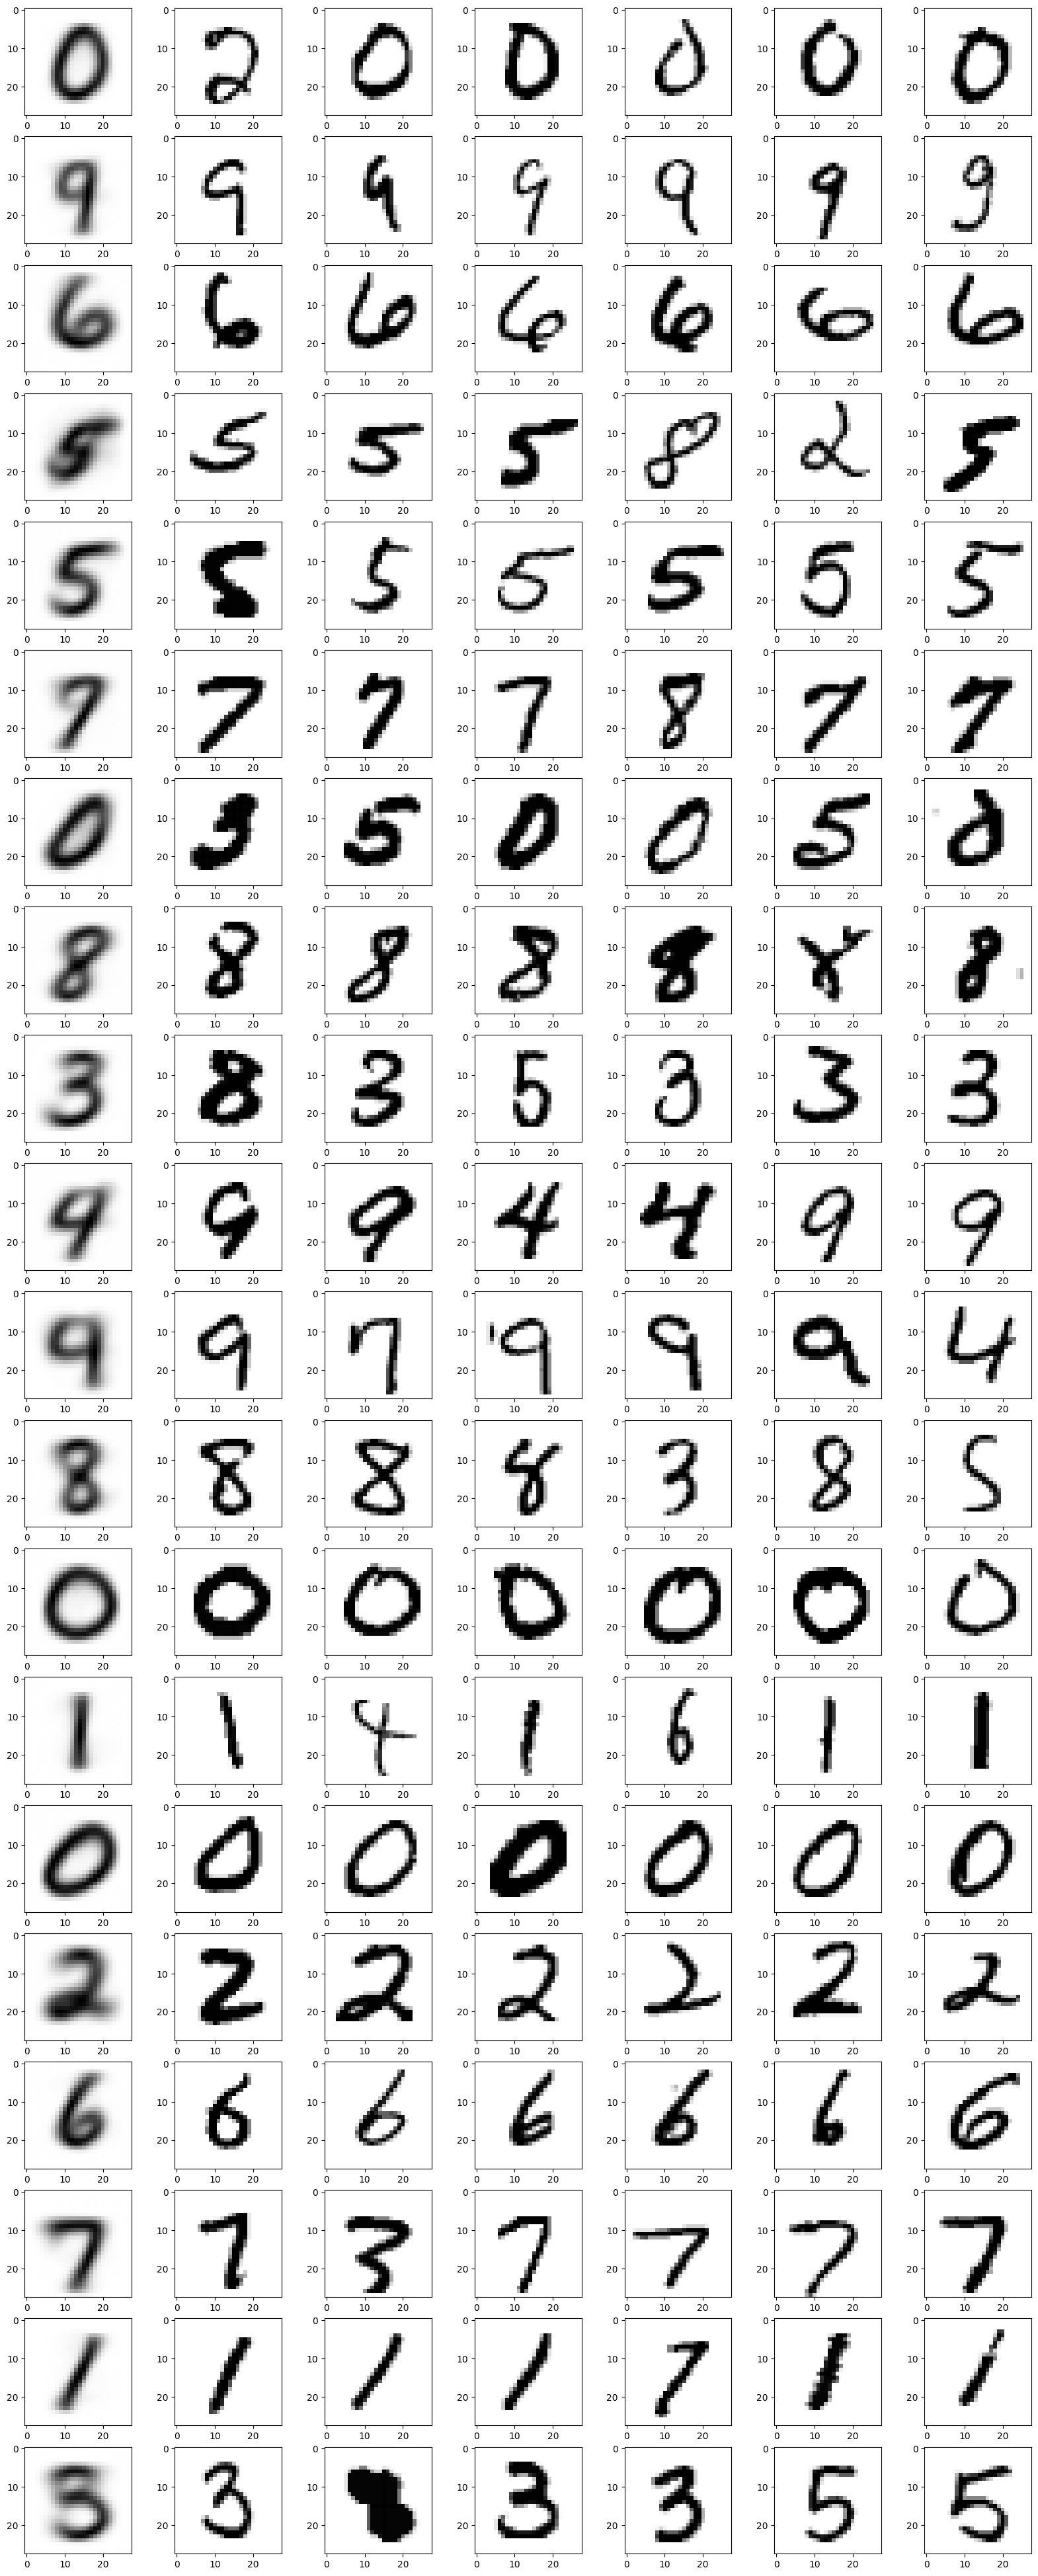

In [29]:
graphic_numbers(centroids, pred_y, image_set, original_shape)

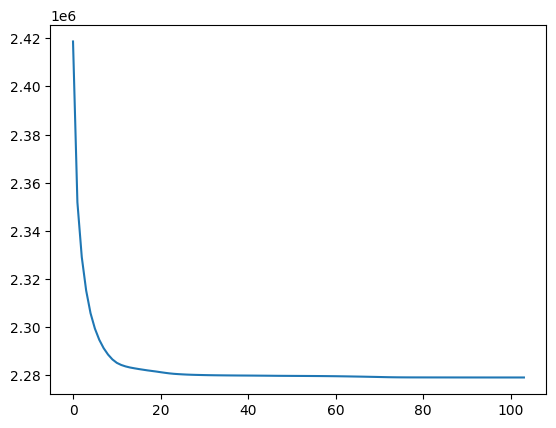

In [30]:
inertia_list = kmeans.inertia[1:]
_ = plt.plot(range(len(inertia_list)), inertia_list)

### Comparación de los resultados del cluster antes y después del SVD

Esta comparación es altamente subjetiva, pues algunas de las imágenes del dataset pueden llegar a ser debatibles. Además, el algoritmo implementado busca los centroides calculando la media entre vectores, lo que implica que los centroides en general no pertenecen al dataset, por lo que en ocasiones las imágenes de dichos centroides son difusas. Otro dato importante para esta comparación es que hay que tener en cuenta que se esta realizando un agrupamiento de las imágenes en 20 cluster cuando las imágenes representa números de 0-9 por lo que de forma natural deberían haber 20 clusters.

Partiendo de esa base, la siguientes sumas son las fracciones de (casos positivos)/ejemplos según mi criterio subjetivo con respecto al agrupamiento y los ejemplos que se muestran en el presente notebook con los resultados entregados. Si el notebook se vuelve a ejecutar es muy probable que estos números no coincida. Además en la primera suma faltan sumandos porque algunos de los centroides me fueron complicados distinguirlos.   

In [31]:
a = 4/6 + 4/6 + 5/6 + 2/6 + 1 + 5/6 + 1 + 1 + 1 + 5/6 + 1 + 5/6 + 1 + 4/6 + 1 + 5/6 + 5/6 + 1 
b = 5/6 + 1 + 1 + 4/6 + 1 + 5/6 + 3/6 + 1 + 4/6 + 4/6 + 1 + 4/6 + 4/6 + 1 + 4/6 + 1 + 1 + 1 + 5/6 + 6/6 + 3/6

a, b

(15.333333333333334, 17.5)

Dado estos resultados según mi opinión al reducir dimensiones se aprecia una mejoría en el agrupamiento, los centroides son más claros y los ejemplos son más cercanos. 

Por otro lado, en este último caso se cumplieron las 100 iteraciones, no se alcanzo ninguno de los otros criterios de parada. Pero al visualizar la gráfica de la inercia se nota la necesidad de agregar un criterio de parada relacionado la inercia pues probablemente el número de iteraciones óptimas en este casos debe estar cercana a las 20.   